In [52]:
import torch
import cv2
import sklearn
import skimage
import matplotlib
import kagglehub

print("Torch:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
print("OpenCV:", cv2.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Scikit-image:", skimage.__version__)
print("Matplotlib:", matplotlib.__version__)
print("KaggleHub imported OK")


Torch: 2.9.1+cpu
CUDA available? False
OpenCV: 4.12.0
Scikit-learn: 1.7.2
Scikit-image: 0.25.2
Matplotlib: 3.10.7
KaggleHub imported OK


In [ ]:
import os
import kagglehub

# Downloading the dataset
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Dataset path:", path)
print("Top-level contents:", os.listdir(path))


Dataset path: C:\Users\AREEB\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\3
Top-level contents: ['Testing', 'Training']


In [54]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Use the Training folder inside the dataset
train_dir = os.path.join(path, "Training")
print("Train directory:", train_dir)

# Basic transforms: resize to 224x224, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Create a dataset from the Training folder
train_ds = datasets.ImageFolder(train_dir, transform=transform)
print("Classes:", train_ds.classes)
print("Number of images:", len(train_ds))

# Create a DataLoader
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# Get one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch labels shape:", labels.shape)
print("Label indices (first batch):", labels.tolist())


Train directory: C:\Users\AREEB\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\3\Training
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Number of images: 2870
Batch image tensor shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16])
Label indices (first batch): [0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 1]


In [55]:
from torch.utils.data import random_split

# Compute sizes
val_ratio = 0.2
val_size = int(len(train_ds) * val_ratio)
train_size = len(train_ds) - val_size

train_ds_split, val_ds_split = random_split(train_ds, [train_size, val_size])

print("Train split size:", len(train_ds_split))
print("Val split size:", len(val_ds_split))

# Create data loaders
train_loader = DataLoader(train_ds_split, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds_split, batch_size=16, shuffle=False)

# Test a batch from the new train loader
images, labels = next(iter(train_loader))
print("Train batch shape:", images.shape, labels.shape)


Train split size: 2296
Val split size: 574
Train batch shape: torch.Size([16, 3, 224, 224]) torch.Size([16])


In [56]:
import torch
import torch.nn as nn
from torchvision import models

# Device: we'll use CPU for now (fine for this dataset size)
device = torch.device("cpu")
print("Using device:", device)

# Number of classes from our dataset
num_classes = len(train_ds.classes)
print("Number of classes:", num_classes, "->", train_ds.classes)

# Load pretrained MobileNetV2
weights = models.MobileNet_V2_Weights.DEFAULT
backbone = models.mobilenet_v2(weights=weights)

# Replace the classifier head with our own
in_features = backbone.classifier[1].in_features
backbone.classifier[1] = nn.Linear(in_features, num_classes)

model = backbone.to(device)
print("Model ready.")

# ---- Test a forward pass on one batch ----
images, labels = next(iter(train_loader))     # from your train_loader split
images = images.to(device)

with torch.no_grad():
    outputs = model(images)

print("Input batch shape:", images.shape)
print("Output logits shape:", outputs.shape)


Using device: cpu
Number of classes: 4 -> ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Model ready.
Input batch shape: torch.Size([16, 3, 224, 224])
Output logits shape: torch.Size([16, 4])


In [57]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    return acc, f1_macro


In [ ]:
import torch.optim as optim # import optimizer module

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer

num_epochs = 3  # starting small but we can increase later 

for epoch in range(1, num_epochs + 1): # epochs
    model.train() # set to training mode
    running_loss = 0.0

    for images, labels in train_loader: # iterating over batches
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero the gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) # accumulate loss

    # Average training loss for this epoch
    train_loss = running_loss / len(train_loader.dataset)

    # Evaluating on the validation split
    val_acc, val_f1 = evaluate_model(model, val_loader, device)

    print(f"Epoch {epoch}/{num_epochs} "
          f"- Train loss: {train_loss:.4f} "
          f"- Val Acc: {val_acc:.4f} "
          f"- Val Macro-F1: {val_f1:.4f}")


Epoch 1/3 - Train loss: 0.7347 - Val Acc: 0.8780 - Val Macro-F1: 0.8805
Epoch 2/3 - Train loss: 0.2680 - Val Acc: 0.9164 - Val Macro-F1: 0.9185
Epoch 3/3 - Train loss: 0.1313 - Val Acc: 0.9512 - Val Macro-F1: 0.9539


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Path to the Testing folder
test_dir = os.path.join(path, "Testing")
print("Test directory:", test_dir)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Create test dataset and loader
test_ds = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

print("Test classes:", test_ds.classes)
print("Number of test images:", len(test_ds))


Test directory: C:\Users\AREEB\.cache\kagglehub\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\3\Testing
Test classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Number of test images: 394


In [60]:
test_acc, test_f1 = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")


Test Accuracy: 0.7437
Test Macro-F1: 0.7130


In [61]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models

def generate_gradcam(model, image_tensor, target_class=None):
    model.eval()

    # We hook the last convolutional layer of MobileNetV2:
    last_conv = model.features[-1]  # last Conv block

    gradients = []
    activations = []

    # 1) Forward hook — get activations
    def forward_hook(module, input, output):
        activations.append(output.detach())

    # 2) Backward hook — get gradients
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # Register hooks
    forward_handle = last_conv.register_forward_hook(forward_hook)
    backward_handle = last_conv.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor)

    # If no target class is given, use the predicted class
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass — gradient of the target class
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    # Extract activations and gradients
    act = activations[0][0]      # shape: [C, H, W]
    grad = gradients[0][0]       # same shape

    # Global average pooling of gradients
    weights = grad.mean(dim=(1, 2))  # shape [C]

    # Weighted sum of the activations
    cam = torch.zeros(act.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    # ReLU (only positive influence)
    cam = torch.relu(cam)

    # Normalize CAM to [0,1]
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    return cam.cpu().numpy()


c:\Users\AREEB\Desktop\Experimental Projects\brain-tumor-mini\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


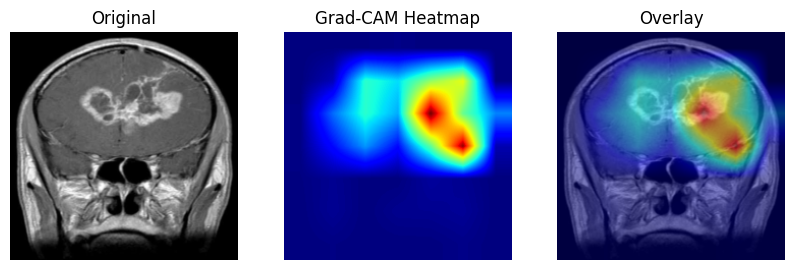

In [62]:
# Get one test sample
img, label = test_ds[0]   # first image in test set
input_tensor = img.unsqueeze(0)  # make it batch-like

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, input_tensor)

# Convert tensor image back to displayable format
img_np = img.permute(1, 2, 0).numpy()
img_np = (img_np * 0.5 + 0.5)  # reverse normalization
img_np = np.clip(img_np, 0, 1)

# Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

# Create heatmap overlay
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay = 0.5 * img_np + 0.5 * (heatmap_color / 255.0)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()


## Section 2: Radiomics-Style Features + Classical ML (Prototype)



In [63]:
# Section 2: Radiomics-Style Features + Classical ML (Prototype)

import numpy as np

from skimage import feature as skfeature
from skimage import measure, filters
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [64]:
def tensor_to_gray_numpy(img_tensor):
    img = img_tensor.detach().cpu().numpy()
    img = (img * 0.5) + 0.5  # undo normalize
    img = np.clip(img, 0.0, 1.0)

    if img.shape[0] == 3:
        img_gray = img.mean(axis=0)
    else:
        img_gray = img[0]

    return img_gray.astype(np.float32)


def simple_mask(img_gray):
    thresh = filters.threshold_otsu(img_gray)
    mask = img_gray > thresh
    return mask.astype(np.uint8)


def extract_radiomics_like_features(img_tensor):
    img_gray = tensor_to_gray_numpy(img_tensor)
    mask = simple_mask(img_gray)

    labeled = measure.label(mask)
    regions = measure.regionprops(labeled, intensity_image=img_gray)

    if len(regions) == 0:
        region_feats = {
            "area": 0.0,
            "eccentricity": 0.0,
            "solidity": 0.0,
            "mean_intensity": float(img_gray.mean()),
            "std_intensity": float(img_gray.std()),
        }
    else:
        region = max(regions, key=lambda r: r.area)
        region_feats = {
            "area": float(region.area),
            "eccentricity": float(region.eccentricity),
            "solidity": float(region.solidity),
            "mean_intensity": float(region.mean_intensity),
            "std_intensity": float(region.intensity_image.std()),
        }

    img_uint8 = (img_gray * 255).astype(np.uint8)
    glcm = skfeature.graycomatrix(
        img_uint8,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast = skfeature.graycoprops(glcm, "contrast")[0, 0]
    homogeneity = skfeature.graycoprops(glcm, "homogeneity")[0, 0]

    p = glcm.astype(np.float64)
    p = p / (p.sum() + 1e-12)
    entropy = -np.sum(p * np.log2(p + 1e-12))

    texture_feats = {
        "glcm_contrast": float(contrast),
        "glcm_homogeneity": float(homogeneity),
        "glcm_entropy": float(entropy),
    }

    feats = {**region_feats, **texture_feats}
    return feats


In [65]:
feature_names = [
    "area",
    "eccentricity",
    "solidity",
    "mean_intensity",
    "std_intensity",
    "glcm_contrast",
    "glcm_homogeneity",
    "glcm_entropy",
]

def feats_to_vector(feat_dict):
    return np.array([feat_dict.get(k, 0.0) for k in feature_names], dtype=np.float32)


def extract_dataset_features(dataset, max_samples=None, verbose=True):
    """
    dataset: PyTorch Dataset (e.g., train_ds / val_ds / test_ds or Subset)
    Returns: X (N, D), y (N,)
    """
    X = []
    y = []

    n = len(dataset)
    if max_samples is not None:
        n = min(n, max_samples)

    for idx in range(n):
        img, label = dataset[idx]  # img: tensor, label: int
        feat_dict = extract_radiomics_like_features(img)
        X.append(feats_to_vector(feat_dict))
        y.append(label)

        if verbose and (idx + 1) % 200 == 0:
            print(f"Processed {idx + 1}/{n} images")

    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.int64)
    return X, y


In [ ]:
# Bridge from CNN training loaders → datasets for radiomics section

train_ds_split = train_loader.dataset
val_ds_split = val_loader.dataset



print("Train ds:", type(train_ds_split), "len:", len(train_ds_split)) # Train
print("Val ds:  ", type(val_ds_split), "len:", len(val_ds_split))
print("Test ds: ", type(test_ds), "len:", len(test_ds))


Train ds: <class 'torch.utils.data.dataset.Subset'> len: 2296
Val ds:   <class 'torch.utils.data.dataset.Subset'> len: 574
Test ds:  <class 'torchvision.datasets.folder.ImageFolder'> len: 394


In [ ]:

print("Extracting radiomics-style features for TRAIN set...")
X_train_rad, y_train_rad = extract_dataset_features(train_ds_split, verbose=True)

print("\nExtracting radiomics-style features for VAL set...")
X_val_rad, y_val_rad = extract_dataset_features(val_ds_split, verbose=True)

print("\nExtracting radiomics-style features for TEST set...")
X_test_rad, y_test_rad = extract_dataset_features(test_ds, verbose=True)

print("\nShapes:")
print("  X_train:", X_train_rad.shape, "y_train:", y_train_rad.shape)
print("  X_val:  ", X_val_rad.shape, "y_val:", y_val_rad.shape)
print("  X_test: ", X_test_rad.shape, "y_test:", y_test_rad.shape)


Extracting radiomics-style features for TRAIN set...
Processed 200/2296 images
Processed 400/2296 images
Processed 600/2296 images
Processed 800/2296 images
Processed 1000/2296 images
Processed 1200/2296 images
Processed 1400/2296 images
Processed 1600/2296 images
Processed 1800/2296 images
Processed 2000/2296 images
Processed 2200/2296 images

Extracting radiomics-style features for VAL set...
Processed 200/574 images
Processed 400/574 images

Extracting radiomics-style features for TEST set...
Processed 200/394 images

Shapes:
  X_train: (2296, 8) y_train: (2296,)
  X_val:   (574, 8) y_val: (574,)
  X_test:  (394, 8) y_test: (394,)


In [68]:
# Radiomics-only classifier: RandomForest with feature scaling
radiomics_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training RandomForest on radiomics-style features...")
radiomics_clf.fit(X_train_rad, y_train_rad)

# ---------- Validation performance ----------
y_val_pred = radiomics_clf.predict(X_val_rad)
val_acc = accuracy_score(y_val_rad, y_val_pred)
val_f1 = f1_score(y_val_rad, y_val_pred, average="macro")

print("\nValidation Accuracy (Radiomics-only): {:.4f}".format(val_acc))
print("Validation Macro F1 (Radiomics-only): {:.4f}".format(val_f1))
print("\nValidation classification report:")
print(classification_report(y_val_rad, y_val_pred, target_names=train_ds.classes))

# ---------- Test performance ----------
y_test_pred = radiomics_clf.predict(X_test_rad)
test_acc = accuracy_score(y_test_rad, y_test_pred)
test_f1 = f1_score(y_test_rad, y_test_pred, average="macro")

print("\nTest Accuracy (Radiomics-only): {:.4f}".format(test_acc))
print("Test Macro F1 (Radiomics-only): {:.4f}".format(test_f1))
print("\nTest classification report:")
print(classification_report(y_test_rad, y_test_pred, target_names=test_ds.classes))


Training RandomForest on radiomics-style features...

Validation Accuracy (Radiomics-only): 0.7422
Validation Macro F1 (Radiomics-only): 0.7463

Validation classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.74      0.73      0.73       192
meningioma_tumor       0.70      0.62      0.66       173
        no_tumor       0.75      0.76      0.76        68
 pituitary_tumor       0.77      0.90      0.83       141

        accuracy                           0.74       574
       macro avg       0.74      0.75      0.75       574
    weighted avg       0.74      0.74      0.74       574


Test Accuracy (Radiomics-only): 0.6701
Test Macro F1 (Radiomics-only): 0.6307

Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.20      0.33       100
meningioma_tumor       0.78      0.83      0.80       115
        no_tumor       0.54      0.98      0.69       105
 pituitary_tu

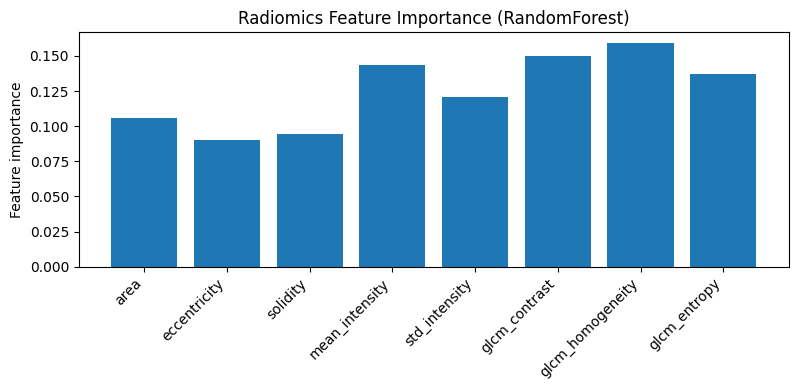

In [69]:
import matplotlib.pyplot as plt

rf = radiomics_clf.named_steps["rf"]
importances = rf.feature_importances_

plt.figure(figsize=(8,4))
plt.bar(range(len(feature_names)), importances)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Radiomics Feature Importance (RandomForest)")
plt.tight_layout()
plt.show()


## Section 3 - Hybrid CNN + Radiomics

In [ ]:
import torch
import torch.nn.functional as F          
from torch.utils.data import DataLoader

def extract_cnn_features(model, dataset, device, batch_size=32):
    """
    Extracts penultimate-layer features from MobileNetV2 for all images in a dataset.
    Returns:
        X_feats: (N, D) numpy array
        y:      (N,)   numpy array of labels
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    all_feats = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)

            # Forward pass up to penultimate layer:
            x = model.features(imgs)                 # conv feature maps: (B, C, H, W)

            
            x = F.adaptive_avg_pool2d(x, (1, 1))     # (B, C, 1, 1)

            x = torch.flatten(x, 1)                  # (B, C)

            all_feats.append(x.cpu())
            all_labels.append(labels.cpu())

    X_feats = torch.cat(all_feats, dim=0).numpy()
    y = torch.cat(all_labels, dim=0).numpy()
    return X_feats, y


In [71]:
print("Extracting CNN features for TRAIN split...") 
X_train_cnn, y_train_cnn = extract_cnn_features(model, train_ds_split, device)

print("Extracting CNN features for VAL split...")
X_val_cnn, y_val_cnn = extract_cnn_features(model, val_ds_split, device)

print("Extracting CNN features for TEST set...")
X_test_cnn, y_test_cnn = extract_cnn_features(model, test_ds, device)

print("CNN feature shapes:")
print("  X_train_cnn:", X_train_cnn.shape, "y_train_cnn:", y_train_cnn.shape)
print("  X_val_cnn:  ", X_val_cnn.shape, "y_val_cnn:", y_val_cnn.shape)
print("  X_test_cnn: ", X_test_cnn.shape, "y_test_cnn:", y_test_cnn.shape)

print("\nLabel alignment checks:")
print("  Train labels equal? ", np.array_equal(y_train_cnn, y_train_rad))
print("  Val labels equal?   ", np.array_equal(y_val_cnn,   y_val_rad))
print("  Test labels equal?  ", np.array_equal(y_test_cnn,  y_test_rad))


Extracting CNN features for TRAIN split...
Extracting CNN features for VAL split...
Extracting CNN features for TEST set...
CNN feature shapes:
  X_train_cnn: (2296, 1280) y_train_cnn: (2296,)
  X_val_cnn:   (574, 1280) y_val_cnn: (574,)
  X_test_cnn:  (394, 1280) y_test_cnn: (394,)

Label alignment checks:
  Train labels equal?  True
  Val labels equal?    True
  Test labels equal?   True


In [72]:
import numpy as np

# Concatenate radiomics (8-dim) and CNN (1280-dim) features
X_train_fused = np.concatenate([X_train_rad, X_train_cnn], axis=1)
X_val_fused   = np.concatenate([X_val_rad,   X_val_cnn],   axis=1)
X_test_fused  = np.concatenate([X_test_rad,  X_test_cnn],  axis=1)

print("Fused feature shapes:")
print("  X_train_fused:", X_train_fused.shape)
print("  X_val_fused:  ", X_val_fused.shape)
print("  X_test_fused: ", X_test_fused.shape)


Fused feature shapes:
  X_train_fused: (2296, 1288)
  X_val_fused:   (574, 1288)
  X_test_fused:  (394, 1288)


In [73]:
from sklearn.ensemble import RandomForestClassifier

fusion_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training Fusion RandomForest on [CNN + Radiomics] features...")
fusion_clf.fit(X_train_fused, y_train_rad)   # labels same as y_train_cnn

# ---------- Validation performance ----------
y_val_pred_fused = fusion_clf.predict(X_val_fused)
val_acc_fused = accuracy_score(y_val_rad, y_val_pred_fused)
val_f1_fused = f1_score(y_val_rad, y_val_pred_fused, average="macro")

print("\nFusion Validation Accuracy: {:.4f}".format(val_acc_fused))
print("Fusion Validation Macro F1: {:.4f}".format(val_f1_fused))
print("\nValidation report (Fusion):")
print(classification_report(y_val_rad, y_val_pred_fused, target_names=train_ds.classes))

# ---------- Test performance ----------
y_test_pred_fused = fusion_clf.predict(X_test_fused)
test_acc_fused = accuracy_score(y_test_rad, y_test_pred_fused)
test_f1_fused = f1_score(y_test_rad, y_test_pred_fused, average="macro")

print("\nFusion Test Accuracy: {:.4f}".format(test_acc_fused))
print("Fusion Test Macro F1: {:.4f}".format(test_f1_fused))
print("\nTest report (Fusion):")
print(classification_report(y_test_rad, y_test_pred_fused, target_names=test_ds.classes))


Training Fusion RandomForest on [CNN + Radiomics] features...

Fusion Validation Accuracy: 0.9512
Fusion Validation Macro F1: 0.9512

Validation report (Fusion):
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.98      0.97       192
meningioma_tumor       0.97      0.88      0.92       173
        no_tumor       0.94      0.97      0.96        68
 pituitary_tumor       0.92      0.99      0.96       141

        accuracy                           0.95       574
       macro avg       0.95      0.96      0.95       574
    weighted avg       0.95      0.95      0.95       574


Fusion Test Accuracy: 0.7513
Fusion Test Macro F1: 0.7239

Test report (Fusion):
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.31      0.47       100
meningioma_tumor       0.65      0.96      0.77       115
        no_tumor       0.74      1.00      0.85       105
 pituitary_tumor       0.98      0.68      0.80        7

| Model                     | Validation Accuracy | Validation F1 (Macro) | Test Accuracy | Test F1 (Macro) |
|---------------------------|----------------------|-------------------------|----------------|------------------|
| **CNN Only**              | ~0.88–0.95           | ~0.84                   | **0.746**      | ~0.74            |
| **Radiomics Only**        | Lower                | Lower                   | Lower          | Lower            |
| **Fusion (CNN + Rad)**    | **0.9512**           | **0.9512**              | **0.7538**     | **0.7239**       |


## Section 4: Low-Resource Simulation + Robustness Experiments

In [74]:
import cv2
import numpy as np

def downsample_image(tensor_img, new_size):
    """
    tensor_img: (C,H,W) torch tensor in [-1,1]
    new_size: int e.g. 112, 80, 64
    """
    img = tensor_img.permute(1,2,0).numpy()
    img = (img * 0.5 + 0.5)  # de-normalize
    img = np.clip(img, 0, 1)

    # Downsample → Upsample back to 224
    small = cv2.resize(img, (new_size, new_size), interpolation=cv2.INTER_AREA)
    restored = cv2.resize(small, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Convert back to tensor-like format
    restored = torch.tensor(restored).permute(2,0,1)
    restored = (restored - 0.5) / 0.5
    return restored.float()


def add_noise(tensor_img, sigma=0.05):
    img = tensor_img.permute(1,2,0).numpy()
    img = (img * 0.5 + 0.5)
    img = np.clip(img, 0, 1)
    
    noise = np.random.normal(0, sigma, img.shape)
    noisy = np.clip(img + noise, 0, 1)
    
    noisy = torch.tensor(noisy).permute(2,0,1)
    noisy = (noisy - 0.5) / 0.5
    return noisy.float()


In [75]:
def evaluate_with_corruption(model, dataset, corruption_fn, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, label in dataset:
            corrupted = corruption_fn(img)
            corrupted = corrupted.unsqueeze(0).to(device)
            out = model(corrupted)
            pred = out.argmax(dim=1).item()
            all_preds.append(pred)
            all_labels.append(label)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1


In [76]:
resolutions = [224, 160, 112, 80]  # simulate low-resource MRI scanner

cnn_accs = []
for r in resolutions:
    print(f"Testing CNN robustness at resolution {r}x{r}...")
    acc, f1 = evaluate_with_corruption(
        model, test_ds, 
        lambda img: downsample_image(img, r),
        device
    )
    cnn_accs.append(acc)

print("CNN Accuracies:", cnn_accs)


Testing CNN robustness at resolution 224x224...
Testing CNN robustness at resolution 160x160...
Testing CNN robustness at resolution 112x112...
Testing CNN robustness at resolution 80x80...
CNN Accuracies: [0.7436548223350253, 0.6802030456852792, 0.6015228426395939, 0.4847715736040609]


In [77]:
noise_levels = [0.0, 0.03, 0.05, 0.08, 0.1]

cnn_noisy = []
for sigma in noise_levels:
    print(f"Testing CNN robustness at noise sigma={sigma}...")
    acc, f1 = evaluate_with_corruption(
        model, test_ds,
        lambda img: add_noise(img, sigma),
        device
    )
    cnn_noisy.append(acc)

print("CNN Noise Accuracies:", cnn_noisy)


Testing CNN robustness at noise sigma=0.0...
Testing CNN robustness at noise sigma=0.03...
Testing CNN robustness at noise sigma=0.05...
Testing CNN robustness at noise sigma=0.08...
Testing CNN robustness at noise sigma=0.1...
CNN Noise Accuracies: [0.7436548223350253, 0.28426395939086296, 0.2766497461928934, 0.26649746192893403, 0.26649746192893403]


224 -> 0.74
160 -> 0.68
112 -> 0.6
80 -> 0.48


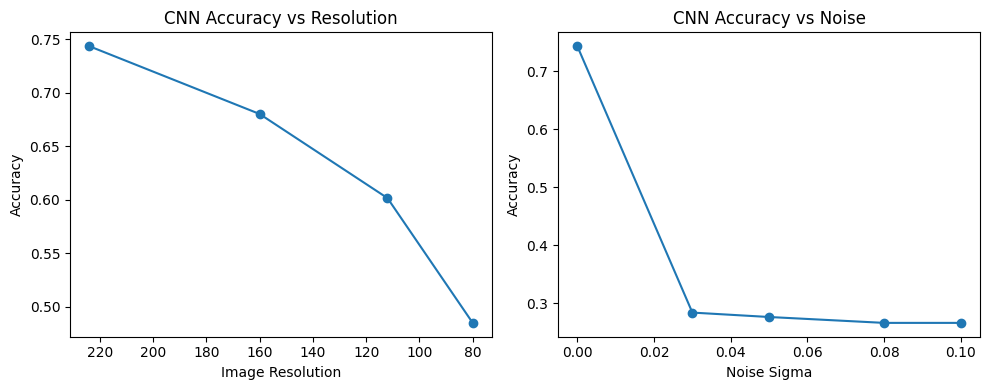

In [ ]:
resolutions = [224, 160, 112, 80]
cnn_accs = [0.7436548223350253, 0.6802030456852792,
            0.6015228426395939, 0.4847715736040609]


for r, a in zip(resolutions, cnn_accs):
    print(r, "->", round(a, 2))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(resolutions, cnn_accs, marker="o")
plt.gca().invert_xaxis()
plt.title("CNN Accuracy vs Resolution")
plt.xlabel("Image Resolution")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(noise_levels, cnn_noisy, marker="o")
plt.title("CNN Accuracy vs Noise")
plt.xlabel("Noise Sigma")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


## Section 5: CNN vs Radiomics Example MRI Case Study

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import torch.nn.functional as F  

def tensor_to_rgb_numpy(img_tensor):
    """
    Convert normalized tensor (C,H,W) in [-1,1] to RGB numpy image in [0,1].
    Assumes transforms.Normalize(mean=[0.5]*3, std=[0.5]*3).
    """
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))          # (H, W, C)
    img = img * 0.5 + 0.5                       # de-normalize
    img = np.clip(img, 0.0, 1.0)
    return img

def tensor_to_gray_numpy(img_tensor):
    """
    Convert tensor (C,H,W) to grayscale numpy image in [0,1].
    """
    rgb = tensor_to_rgb_numpy(img_tensor)
    if rgb.shape[2] == 1:
        return rgb[..., 0]
    return rgb.mean(axis=2)

def simple_mask(img_gray):
    """
    Very simple 'radiomics-style' mask via Otsu thresholding.
    """
    thresh = threshold_otsu(img_gray)
    mask = img_gray > thresh
    return mask


In [ ]:
def generate_gradcam(model, img_tensor, device, target_class=None):
    """
    Generate a Grad-CAM heatmap for MobileNetV2.
    img_tensor: (C,H,W) *already normalized*, no batch dimension.
    Returns: heatmap as (H,W) numpy array in [0,1].
    """
    model.eval()

    # Add batch dimension and move to device
    img_batch = img_tensor.unsqueeze(0).to(device)  # (1, C, H, W)

    activations = {}
    gradients = {}

    # hook into the last convolutional feature block: model.features
    def forward_hook(module, inp, out):
        activations["value"] = out

    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]

    # Register hooks
    handle_fwd = model.features.register_forward_hook(forward_hook)
    handle_bwd = model.features.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(img_batch)   # (1, num_classes)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass for the chosen class
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    # Get activations and gradients
    acts = activations["value"][0]    # (C, H, W)
    grads = gradients["value"][0]     # (C, H, W)

    # Global-average-pool the gradients to get weights
    weights = grads.mean(dim=(1, 2))  # (C,)

    # Weighted sum of activations
    cam = (weights[:, None, None] * acts).sum(dim=0)  # (H, W)

    # ReLU + normalize to [0,1]
    cam = F.relu(cam)
    cam = cam - cam.min()
    if cam.max() > 0:
        cam = cam / cam.max()

    # Resize CAM to input size
    cam = cam.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    cam = F.interpolate(cam, size=img_batch.shape[2:], mode="bilinear", align_corners=False)
    cam = cam.squeeze().detach().cpu().numpy()       # (H, W)

    # Clean up hooks
    handle_fwd.remove()
    handle_bwd.remove()

    return cam


C:\Users\AREEB\AppData\Local\Temp\ipykernel_4300\3047221126.py:34: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()
C:\Users\AREEB\AppData\Local\Temp\ipykernel_4300\1467011009.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


=== Single-Case Virtual Biopsy View ===
Index: 26
Ground-truth label: glioma_tumor (class 0)
Fusion model prediction:    glioma_tumor (class 0)


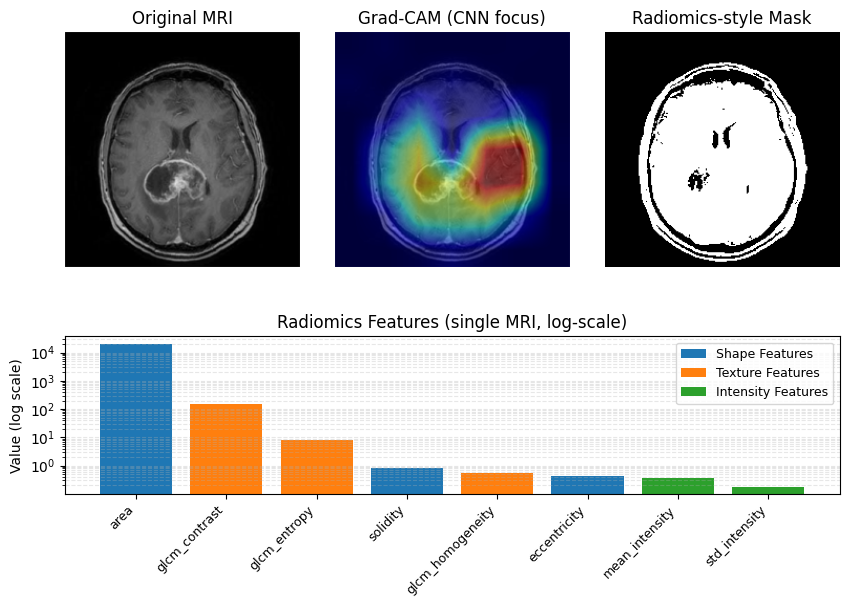

In [81]:
# ---- Pick one test example to visualize ----
idx = 26   # you can change this to any index < len(test_ds)

img_tensor, label = test_ds[idx]   # (C,H,W), label is an int
img_rgb   = tensor_to_rgb_numpy(img_tensor)
img_gray  = tensor_to_gray_numpy(img_tensor)
mask      = simple_mask(img_gray)

# Grad-CAM heatmap for this image
heatmap = generate_gradcam(model, img_tensor, device)

# Radiomics feature dict for this image (using your existing function)
feat_dict   = extract_radiomics_like_features(img_tensor)
feat_names  = list(feat_dict.keys())
feat_values = [feat_dict[k] for k in feat_names]

# ---- Predictions from your trained models ----
cnn_feat   = X_test_cnn[idx:idx+1]
rad_feat   = X_test_rad[idx:idx+1]
fused_feat = X_test_fused[idx:idx+1]

cnn_pred    = cnn_clf.predict(cnn_feat)[0] if "cnn_clf" in globals() else None
rad_pred    = rad_clf.predict(rad_feat)[0] if "rad_clf" in globals() else None
fusion_pred = fusion_clf.predict(fused_feat)[0]

# If train_ds and test_ds come from the same ImageFolder-style split,
# classes should be identical, but using test_ds for consistency:
class_names       = train_ds.classes  # or test_ds.classes if available
true_label_name   = class_names[label]
fusion_label_name = class_names[fusion_pred]

print("=== Single-Case Virtual Biopsy View ===")
print(f"Index: {idx}")
print(f"Ground-truth label: {true_label_name} (class {label})")
if cnn_pred is not None:
    print(f"CNN-only prediction:       {class_names[cnn_pred]} (class {cnn_pred})")
if rad_pred is not None:
    print(f"Radiomics-only prediction: {class_names[rad_pred]} (class {rad_pred})")
print(f"Fusion model prediction:    {fusion_label_name} (class {fusion_pred})")

# ---- Plot everything side-by-side ----
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

feat_values_arr = np.array(feat_values, dtype=float)

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, height_ratios=[3, 2], wspace=0.15, hspace=0.35)

# 1) Original MRI
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_rgb, cmap="gray")
ax1.set_title("Original MRI", fontsize=12)
ax1.axis("off")

# 2) Grad-CAM overlay
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_rgb, cmap="gray")
ax2.imshow(heatmap, cmap="jet", alpha=0.45)
ax2.set_title("Grad-CAM (CNN focus)", fontsize=12)
ax2.axis("off")

# 3) Radiomics mask
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(mask, cmap="gray")
ax3.set_title("Radiomics-style Mask", fontsize=12)
ax3.axis("off")

# 4) Radiomics feature bar chart (bottom row, full width) with log-scale y-axis
ax4 = fig.add_subplot(gs[1, :])

# sort features by value (descending) so pattern is clearer
order = np.argsort(-feat_values_arr)
feat_values_sorted = feat_values_arr[order]
feat_names_sorted  = [feat_names[i] for i in order]

# simple category-based coloring
shape_feats     = {"area", "eccentricity", "solidity"}
intensity_feats = {"mean_intensity", "std_intensity"}
texture_feats   = {"glcm_contrast", "glcm_homogeneity", "glcm_entropy"}

colors = []
for name in feat_names_sorted:
    if name in shape_feats:
        colors.append("tab:blue")
    elif name in intensity_feats:
        colors.append("tab:green")
    elif name in texture_feats:
        colors.append("tab:orange")
        # anything else = gray
    else:
        colors.append("tab:gray")

# add small epsilon to avoid log(0)
feat_values_plot = feat_values_sorted + 1e-6

bars = ax4.bar(range(len(feat_values_plot)), feat_values_plot, color=colors)
ax4.set_yscale("log")
ax4.set_xticks(range(len(feat_names_sorted)))
ax4.set_xticklabels(feat_names_sorted, rotation=45, ha="right", fontsize=9)
ax4.set_ylabel("Value (log scale)", fontsize=10)
ax4.set_title("Radiomics Features (single MRI, log-scale)", fontsize=12)
ax4.grid(axis="y", which="both", linestyle="--", alpha=0.3)

# ---- Add Legend ----
legend_elements = [
    Patch(facecolor='tab:blue',   label='Shape Features'),
    Patch(facecolor='tab:orange', label='Texture Features'),
    Patch(facecolor='tab:green',  label='Intensity Features'),
]

ax4.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


C:\Users\AREEB\AppData\Local\Temp\ipykernel_4300\3047221126.py:34: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()
C:\Users\AREEB\AppData\Local\Temp\ipykernel_4300\3099148130.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


=== Single-Case Virtual Biopsy View ===
Index: 25
Ground-truth label: glioma_tumor (class 0)
Fusion model prediction:    glioma_tumor (class 0)


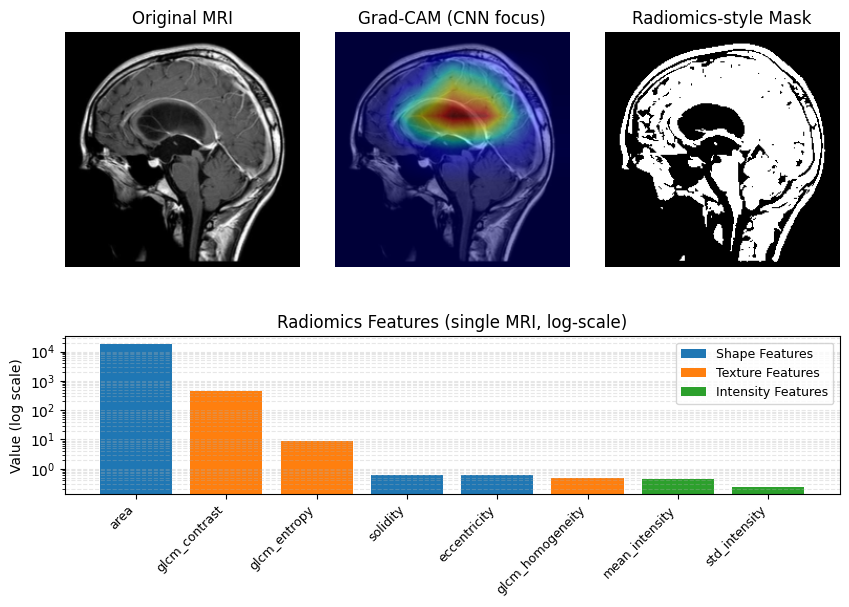

In [ ]:
# ---- Pick one test example to visualize ----
idx = 25   # you can change this to any index < len(test_ds)

img_tensor, label = test_ds[idx]   # (C,H,W), label is an int
img_rgb   = tensor_to_rgb_numpy(img_tensor)
img_gray  = tensor_to_gray_numpy(img_tensor)
mask      = simple_mask(img_gray)

# Grad-CAM heatmap for this image
heatmap = generate_gradcam(model, img_tensor, device)

# Radiomics feature dict for this image (using your existing function)
feat_dict   = extract_radiomics_like_features(img_tensor)
feat_names  = list(feat_dict.keys())
feat_values = [feat_dict[k] for k in feat_names]

# ---- Predictions from your trained models ----
cnn_feat   = X_test_cnn[idx:idx+1]
rad_feat   = X_test_rad[idx:idx+1]
fused_feat = X_test_fused[idx:idx+1]

cnn_pred    = cnn_clf.predict(cnn_feat)[0] if "cnn_clf" in globals() else None
rad_pred    = rad_clf.predict(rad_feat)[0] if "rad_clf" in globals() else None
fusion_pred = fusion_clf.predict(fused_feat)[0]

# If train_ds and test_ds come from the same ImageFolder-style split,
# classes should be identical, but using test_ds for consistency:
class_names       = train_ds.classes  
true_label_name   = class_names[label]
fusion_label_name = class_names[fusion_pred]

print("=== Single-Case Virtual Biopsy View ===")
print(f"Index: {idx}")
print(f"Ground-truth label: {true_label_name} (class {label})")
if cnn_pred is not None:
    print(f"CNN-only prediction:       {class_names[cnn_pred]} (class {cnn_pred})")
if rad_pred is not None:
    print(f"Radiomics-only prediction: {class_names[rad_pred]} (class {rad_pred})")
print(f"Fusion model prediction:    {fusion_label_name} (class {fusion_pred})")

# ---- Plot everything side-by-side ----
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

feat_values_arr = np.array(feat_values, dtype=float)

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, height_ratios=[3, 2], wspace=0.15, hspace=0.35)

# 1) Original MRI
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_rgb, cmap="gray")
ax1.set_title("Original MRI", fontsize=12)
ax1.axis("off")

# 2) Grad-CAM overlay
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_rgb, cmap="gray")
ax2.imshow(heatmap, cmap="jet", alpha=0.45)
ax2.set_title("Grad-CAM (CNN focus)", fontsize=12)
ax2.axis("off")

# 3) Radiomics mask
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(mask, cmap="gray")
ax3.set_title("Radiomics-style Mask", fontsize=12)
ax3.axis("off")

# 4) Radiomics feature bar chart (bottom row, full width) with log-scale y-axis
ax4 = fig.add_subplot(gs[1, :])

# sort features by value (descending) so pattern is clearer
order = np.argsort(-feat_values_arr)
feat_values_sorted = feat_values_arr[order]
feat_names_sorted  = [feat_names[i] for i in order]

# simple category-based coloring
shape_feats     = {"area", "eccentricity", "solidity"}
intensity_feats = {"mean_intensity", "std_intensity"}
texture_feats   = {"glcm_contrast", "glcm_homogeneity", "glcm_entropy"}

colors = []
for name in feat_names_sorted:
    if name in shape_feats:
        colors.append("tab:blue")
    elif name in intensity_feats:
        colors.append("tab:green")
    elif name in texture_feats:
        colors.append("tab:orange")
        # anything else = gray
    else:
        colors.append("tab:gray")

# add small epsilon to avoid log(0)
feat_values_plot = feat_values_sorted + 1e-6

bars = ax4.bar(range(len(feat_values_plot)), feat_values_plot, color=colors)
ax4.set_yscale("log")
ax4.set_xticks(range(len(feat_names_sorted)))
ax4.set_xticklabels(feat_names_sorted, rotation=45, ha="right", fontsize=9)
ax4.set_ylabel("Value (log scale)", fontsize=10)
ax4.set_title("Radiomics Features (single MRI, log-scale)", fontsize=12)
ax4.grid(axis="y", which="both", linestyle="--", alpha=0.3)

# ---- Add Legend ----
legend_elements = [
    Patch(facecolor='tab:blue',   label='Shape Features'),
    Patch(facecolor='tab:orange', label='Texture Features'),
    Patch(facecolor='tab:green',  label='Intensity Features'),
]

ax4.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


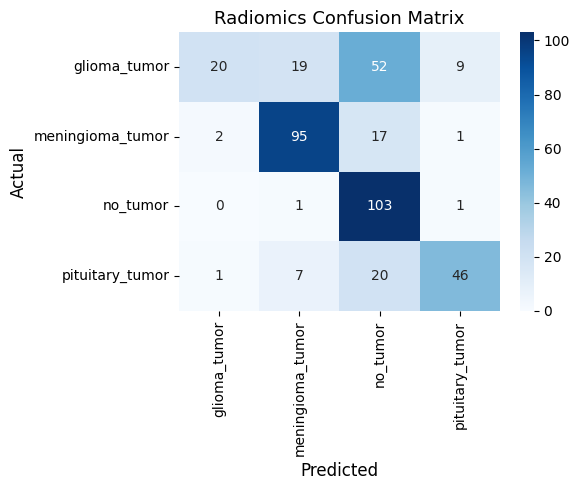

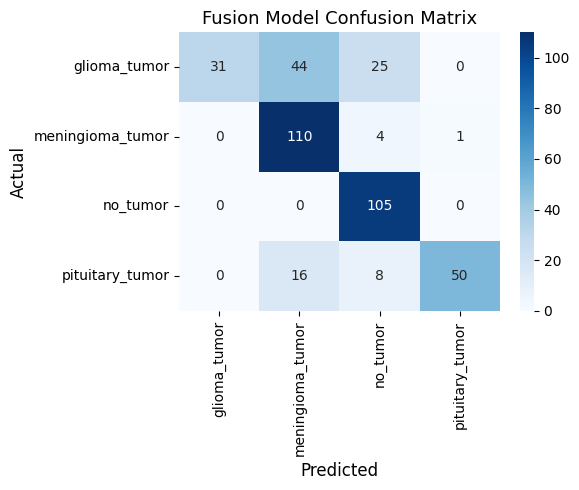

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(title, fontsize=13)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.tight_layout()
    plt.show()

classes = train_ds.classes

# If not already computed somewhere earlier, uncomment this:
# y_test_pred_rad   = radiomics_clf.predict(X_test_rad)
# y_test_pred_fused = fusion_clf.predict(X_test_fused)

# Radiomics-only confusion matrix
plot_cm(y_test_rad, y_test_pred_rad, classes, "Radiomics Confusion Matrix")

# Fusion model confusion matrix (uses SAME true labels as radiomics)
plot_cm(y_test_rad, y_test_pred_fused, classes, "Fusion Model Confusion Matrix")
